# Multithreading

## What are threads?
Threads are **execution units within a process** that can run simultaneously. While processes are separate, threads run in a **shared memory** space (heap).

<!-- <img src="./imgs/what-are-threads.png" width=500px> -->

<br>
<img src="imgs/stack_heap_threads.svg" width=450px>
<br>

## Starting Julia with multiple threads

By default, Julia starts with a single *user thread*. We must tell it explicitly to start multiple user threads. There are two ways to do this:

* Environment variable: `JULIA_NUM_THREADS=4`
* Command line argument: `julia -t 4`

**PC2 Jupyter Hub**

- Select a kernel with e.g. **8 threads**:

<img src="imgs/kernels.png" width=300px>

**It is currently not (easily) possible to change the number of threads at runtime!**

We can readily check how many threads we are running:

In [1]:
Threads.nthreads()

20

### User threads vs default threads

Technically, the Julia process is also spawning multiple threads already in "single-threaded" mode, like
* a thread for unix signal listening
* multiple OpenBLAS threads for BLAS/LAPACK operations
* GC threads

We call the threads that we can actually run computations on *user threads* or *Julia threads*.

In [2]:
using LinearAlgebra
BLAS.get_num_threads()

10

## Where are my threads running?

### Noctua 2 compute node

In [3]:
using ThreadPinning

In [4]:
threadinfo()


System: 10 cores (2-way SMT), 1 sockets, 1 NUMA domains

| 

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,
  16,17,18,19 | 

# = Julia thread, # = HT, # = Julia thread on HT, | = Socket seperator

Julia threads: 20
├ Occupied CPU-threads: 16
└ Mapping (Thread => CPUID): 1 => 19, 2 => 11, 3 => 13, 4 => 1, 5 => 0, ...


`lstopo_no_graphics`

<img src="imgs/lstopo_noctua2.svg" width=80%>

##### "Hyperthreading" (not active on Noctua 2)

<img src="imgs/threadinfo.png" width=1000px>

## Task-based multithreading

In traditional HPC, one typically cares about threads directly. Using e.g. OpenMP, one essentially tells each thread what to do.

Conceptually, Julia takes a different approach and implements **task-based** multithreading. In this paradigm, a task - e.g. a computational piece of a code - is marked for **parallel** execution on **any** of the available Julia threads. Julia's **dynamic scheduler** will automatically put the task on one of the threads and trigger the execution of the task on said thread.

<br>
<!-- <img src="imgs/task-based-parallelism.png" width=768px> -->
<img src="imgs/tasks_threads_cores.svg" width=650px>
</br>

Generally speaking, the user should **think about tasks and not threads**.
* The scheduler is controlling on which thread a task will eventually run.
* It might even dynamically [migrate tasks](https://docs.julialang.org/en/v1/manual/multi-threading/#man-task-migration) between threads.

**Advantages:**
* high-level abstraction
* nestability / composability (especially important for libraries)

**Disadvantages:**
* scheduling overhead
* uncertain and potentially suboptimal task → thread assignment
  * **can get in the way when performance engineering** because
    * scheduler has limited information (e.g. about the system topology)
    * profiling tools often don't know anything about tasks but monitor threads (or even CPU-cores) instead (e.g. LIKWID).

### Tasks

By default, Julia waits for commands to finish ("**blocking**") and runs everything sequentially.

**Tasks** are a feature that allows (parts of) computations to be scheduled (suspended and resumed) in a flexible manner to implement **concurrency** and **parallelism**.

* Concurrency
    * Dealing with lots of things *in a time period* ("multi-tasking").
    * Can be used on a single thread.
* Parallelism
    * Doing lots of things *at the same instant*.
    * Needs multiple threads (or processes).

Example (concurrency): **asynchronous I/O** like
  * **multiple user input** (Why not already process some of the input?)
  * **data dumping to disk** (Maybe it's possible to continue a calculation?)
 
Example (parallelism): **multithreading, distributed computing**

### Spawning parallel tasks: `Threads.@spawn`
`Threads.@spawn` spawns a task to be run on any Julia thread. Specifically, it creates a `Task` and schedules it for execution on an available Julia thread (we don't control which one!).

Note that `Threads.@spawn` is **asynchronous** and **non-blocking**, that is, it doesn't wait for the task to actually run but immediately returns a `Task`.

In [5]:
using Base.Threads # afterwards we can just write @spawn instead of Threads.@spawn

In [6]:
@spawn 3+3

Task (done) @0x00007f82dee70fb0

We can fetch the result of a task with `fetch`.

In [7]:
t = @spawn 3+3
fetch(t)

6

While `@spawn` returns right away, `fetch` is **blocking** as it has to wait for the task to actually finish.

In [8]:
@time t = @spawn begin
    sleep(3)
    return 3+3
end
@time fetch(t)

  0.000136 seconds (33 allocations: 2.312 KiB)


  2.968700 seconds (107 allocations: 5.281 KiB)


6

We can use the macro `@sync` to synchronize all encompassed asynchronous operations (`@spawn`).

In [9]:
@time @sync t = @spawn begin
    sleep(3)
    return 3+3
end
@time fetch(t)

  3.023363 seconds (8.16 k allocations: 570.672 KiB, 0.72% compilation time)
  0.000003 seconds


6

#### Example: multithreaded `map`

`tmap`: *threaded map*

In [10]:
function tmap(fn, itr)
    tasks = map(i -> @spawn(fn(i)), itr)  # for each i ∈ itr, spawn a task to compute fn(i)
    return fetch.(tasks)                  # fetch and return all the results
end

tmap (generic function with 1 method)

In [11]:
M = [rand(200,200) for i in 1:8];

In [12]:
tmap(svdvals, M)

8-element Vector{Vector{Float64}}:
 [99.64109591427723, 8.411716076046758, 7.936515101966217, 7.589189367169681, 7.583749764267464, 7.51226038320385, 7.473050353068089, 7.417980821687014, 7.377188469447791, 7.337029334889456  …  0.3022768492172337, 0.2556399639656215, 0.2369347589042417, 0.22335667564289113, 0.16738908334110056, 0.13539639561164937, 0.10420873079275127, 0.06441353760272377, 0.03059409695352177, 0.011900201970349085]
 [100.07758321758851, 7.994024821351012, 7.895290699867822, 7.727443724655954, 7.646638041362115, 7.601436661309439, 7.427931812167159, 7.401124455768659, 7.328461212542204, 7.3140428238758455  …  0.3067102427386096, 0.24924232029025, 0.2053597472858741, 0.17691395517471825, 0.14803159316752296, 0.11435126092661098, 0.08838149761935991, 0.048584892127714205, 0.03223069671007493, 0.004532403319661264]
 [99.90798997366763, 7.92114497614892, 7.856174452455812, 7.726948471750372, 7.603785750988499, 7.512151856098381, 7.47232289787411, 7.379821568118366, 7.33959

In [13]:
using BenchmarkTools

In [15]:
@btime tmap($svdvals, $M) samples=10 evals=3;
@btime map($svdvals, $M) samples=10 evals=3;

  7.875 ms (113 allocations: 3.38 MiB)


  24.821 ms (65 allocations: 3.37 MiB)


**performance issue**:

* Using Julia multithreading + BLAS multithreading
    - CPU cores may be *overscribed*, e.g. 256 total threads on 128 CPU cores! (red bars in `htop`)

If you use BLAS, it is important to carefully consider and configure the [interplay between Julia threads and BLAS threads](https://carstenbauer.github.io/ThreadPinning.jl/stable/explanations/blas/).

In [16]:
BLAS.set_num_threads(1)

In [17]:
@btime tmap($svdvals, $M) samples=10 evals=3;
@btime map($svdvals, $M) samples=10 evals=3;

  4.674 ms (113 allocations: 3.38 MiB)


  19.489 ms (65 allocations: 3.37 MiB)


#### Example: multithreading for-loops

In [18]:
using ThreadPinning: taskid

In [19]:
@sync for i in 1:2*nthreads()
    @spawn println("Task ", taskid(), " is running iteration ", i, " on thread ", threadid())
end

Task 5728370972162303930 is running iteration 14 on thread 5
Task 4023168033851427435 is running iteration 39 on thread 5
Task 12117292481154076151 is running iteration 26 on thread 5
Task 12893208420510524446 is running iteration 40 on thread 10
Task 16941014588338184556 is running iteration 8 on thread 7


Task 16614726687212937300 is running iteration 22 on thread 5
Task 12519414027847347288 is running iteration 5 on thread 3
Task 16334834652781130799 is running iteration 23 on thread 5
Task 102998991242903933 is running iteration 16 on thread 11
Task 4067014055779527206 is running iteration 27 on thread 5


Task 8957919183900272979 is running iteration 2 on thread 17
Task 12005438125974069048 is running iteration 17 on thread 5
Task 17225376990089955234 is running iteration 15 on thread 10
Task 10219188697335935488 is running iteration 38 on thread 18
Task 7185015384751398662 is running iteration 9 on thread 4
Task 17349934348856418006 is running iteration 24 on thread 20
Task 16970712622893066833 is running iteration 31 on thread 5
Task 6816809835453281952 is running iteration 21 on thread 5


Task 10095280958815230551 is running iteration 37 on thread 10
Task 13938343557351115711 is running iteration 4 on thread 6
Task 2708655992665449318 is running iteration 29 on thread 5
Task 16494906707440957510 is running iteration 1 on thread 2
Task 18060768176299880961 is running iteration 32 on thread 5
Task 14135711484528348538 is running iteration 28 on thread 5
Task 5628691249385523566 is running iteration 33 on thread 5
Task 2860838997705207268 is running iteration 7 on thread 9
Task 16232589127278325312 is running iteration 30 on thread 5
Task 6535709308882406911 is running iteration 35 on thread 10
Task 17405782830834898482 is running iteration 13 on thread 14
Task 6146159129334208529 is running iteration 10 on thread 8
Task 9864279048248631184 is running iteration 6 on thread 15
Task 14626232520595453243 is running iteration 11 on thread 13
Task 1262551960254128613 is running iteration 25 on thread 1
Task 603436123253245120 is running iteration 3 on thread 16
Task 25639272899

##### `@threads`

* **Splits up the iteration space into `nthreads()` contiguous chunks**
* Creates a task for each of them.

In [20]:
# creates nthreads() many tasks

@threads for i in 1:2*nthreads()
    println("Task ", taskid(), " is running iteration ", i, " on thread ", threadid())
end

Task 9958339815589378422 is running iteration 1 on thread 6
Task 16779902591066556608 is running iteration 5 on thread 15
Task 7041996877820435672 is running iteration 35 on thread 19
Task 9476071561333345054 is running iteration 31 on thread 14
Task 14249042458023239193 is running iteration 15 on thread 10
Task 2282363778736205645 is running iteration 33 on thread 12
Task 4239789135467829808 is running iteration 11 on thread 16
Task 9545910538507457550 is running iteration 19 on thread 3
Task 14408679146879915003 is running iteration 3 on thread 2
Task 7823782111190999070 is running iteration 25 on thread 4
Task 8738434990456157355 is running iteration 13 on thread 5
Task 4239789135467829808 is running iteration 12 on thread 16
Task 16779902591066556608 is running iteration 6 on thread 15
Task 1815499826274807944 is running iteration 39 on thread 20
Task 3049867900096094570 is running iteration 21 on thread 11
Task 18134742736661143578 is running iteration 37 on thread 1
Task 30498679

### Load-balancing

If there are many tasks (e.g. many more than available threads), Julia's scheduler balances the load of these tasks among threads. (**non-uniform workloads**)

In [21]:
using StatsPlots

In [22]:
function compute_nonuniform_spawn!(a, workloads = [Int[] for _ in 1:nthreads()])
    @sync for i in 1:length(a)
        Threads.@spawn begin
            a[i] = sum(abs2, rand() for j in 1:(2^14*i))   # workload proportional to i
            push!(workloads[threadid()], i)                # (poor-man's) bookkeeping
        end
    end
    return workloads
end

compute_nonuniform_spawn! (generic function with 2 methods)

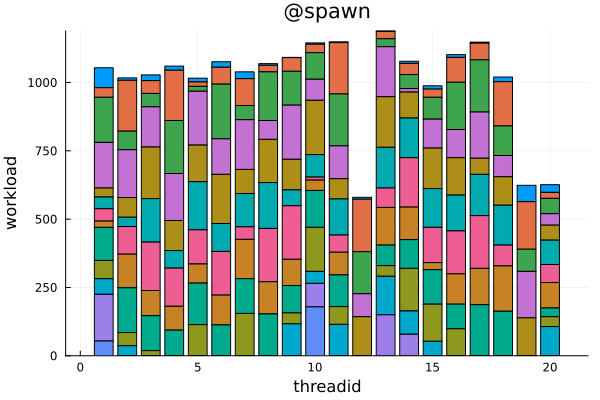

In [23]:
a = zeros(nthreads()*10)
workloads = compute_nonuniform_spawn!(a)

# plotting
thread_workloads = zeros(Int, nthreads(), maximum(length, workloads))
for th in eachindex(workloads)
    for (i, w) in enumerate(workloads[th])
        thread_workloads[th, i] = w
    end
end
b = groupedbar(thread_workloads, xlab="threadid", ylab="workload", title="@spawn", legend=false, bar_position=:stack)
# b = bar(sum.(workloads), xlab="threadid", ylab="workload", title="Workload (@spawn)", legend=false, color=:green)
display(b)

#### No load-balancing with `@threads`

`@threads` doesn't give load-balancing because when it **divides the iteration interval into `nthreads()` tasks** there is no flexibility left to give a thread more than a single task.

In [24]:
function compute_nonuniform_threads!(a, workloads = [Dict() for _ in 1:nthreads()])
    @threads for i in 1:length(a)
        a[i] = sum(abs2, rand() for j in 1:(2^14*i)) # workload proportional to i

        # poor-man's bookkeeping
        d = workloads[threadid()]
        d[taskid()] = get!(d, taskid(), 0) + i
    end
    return workloads
end

compute_nonuniform_threads! (generic function with 2 methods)

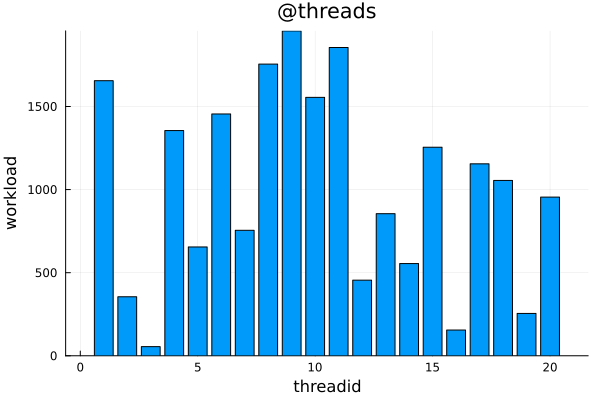

In [25]:
a = zeros(nthreads()*10)
workloads = compute_nonuniform_threads!(a)

# plotting
@assert length(workloads) == nthreads()
b = bar([only(values(w)) for w in workloads], xlab="threadid", ylab="workload", title="@threads", legend=false)
display(b)

**Note:**
* There will likely be a scheduling option for `@threads` that implements load-balancing in the future (see e.g. https://github.com/JuliaLang/julia/pull/52096).

### Nestability / Composability

#### Example: Recursive Fibonacci series

$$ F(n) = F(n-1) + F(n-2), \qquad F(1) = F(2) = 1$$

We can nest `@spawn` calls freely!

In [30]:
function fib(n)
    n < 2 && return n
    t = @spawn fib(n-2)
    return fib(n-1) + fetch(t)
end

fib (generic function with 1 method)

In [31]:
fib(20)

6765

(Note: Algorithmically, this is a highly inefficient implementation of the Fibonacci series, of course!)

## Multithreading: Things to be aware of

### Instructive example: parallel summation

In [32]:
data = rand(1_000_000 * Threads.nthreads());

#### Naive approach

In [33]:
function sum_threads_naive(data)
    s = zero(eltype(data))
    @threads for x in eachindex(data)
        s += x
    end
    return s
end

sum_threads_naive (generic function with 1 method)

In [34]:
@show sum(data);
@show sum_threads_naive(data);
@show sum_threads_naive(data);

sum(data) = 1.0002506701637235e7


sum_threads_naive(data) = 7.511502703058e12


sum_threads_naive(data) = 1.7500885517936e13


**Wrong** result! Even worse, it's **non-deterministic** and different every time!

There is a [race condition](https://en.wikipedia.org/wiki/Race_condition) which typically appear when multiple tasks are modifying a shared value simultaneously.

→ **Don't modify shared "global" state!**

Sometimes things can be more subtle. Examples: random number generation, `Dict`. Note that not all of Julia and its packages in the ecosystem are thread-safe! In general, it is safer to assume that they're not unless documented/proven otherwise. (`rand()` is thread-safe, `Dict` isn't!)

#### Thread-focused partial sums (unsafe)

Our strategy:
* One accumulator variable per thread.

You might be inclined to write something similar to the following (intentionally written in a slightly more verbose form):

In [35]:
function sum_threads_unsafe(data)
    psums = zeros(eltype(data), nthreads())
    @threads for i in eachindex(data)
        current_sum = psums[threadid()] # read
        new_sum = current_sum + data[i] # "work"
        psums[threadid()] = new_sum     # write
    end
    return sum(psums)
end

sum_threads_unsafe (generic function with 1 method)

Such an approach is generally **unsafe** because Julia's scheduler may **migrate tasks between threads**!
  * For example, a task might start on thread 1, is then paused (say, after "work") and migrated to thread 3, where it finishes execution.
  * → The output of `threadid()` might change within a task! To be safe, [don't use `threadid()`](https://julialang.org/blog/2023/07/PSA-dont-use-threadid/) at all!
  
It also goes against the idea of task-based multithreading, as we're **thinking about threads rather than tasks**.

(Note that, in spite of the comments above, the `threadid()` pattern will often still work correctly. This is because as of Julia 1.10 task migrations are very rare. Importantly, **you can't rely on it though!**)

#### Chunk-focused partial sums (safe)

Our strategy:
* Divide the data (indices) into **chunks** and use **one accumulator per chunk**.

The package [ChunkSplitters.jl](https://github.com/m3g/ChunkSplitters.jl) is helpful for chunking (`Iterators.partition` is a built-in alternative).

In [36]:
using ChunkSplitters

In [37]:
collect(chunks(data; n=nthreads())) # number of chunks chosen as nthreads()

20-element Vector{StepRange{Int64, Int64}}:
 1:1:1000000
 1000001:1:2000000
 2000001:1:3000000
 3000001:1:4000000
 4000001:1:5000000
 5000001:1:6000000
 6000001:1:7000000
 7000001:1:8000000
 8000001:1:9000000
 9000001:1:10000000
 10000001:1:11000000
 11000001:1:12000000
 12000001:1:13000000
 13000001:1:14000000
 14000001:1:15000000
 15000001:1:16000000
 16000001:1:17000000
 17000001:1:18000000
 18000001:1:19000000
 19000001:1:20000000

In [38]:
function sum_threads_chunks(data; nchunks=nthreads())
    psums = zeros(eltype(data), nchunks)
    @threads for (c, idcs) in enumerate(chunks(data; n=nchunks))
        for i in idcs
            psums[c] += data[i]
        end
    end
    return sum(psums)
end

sum_threads_chunks (generic function with 1 method)

In [39]:
sum_threads_chunks(data) ≈ sum(data)

true

In [40]:
@btime sum($data);
@btime sum_threads_chunks($data);

  9.535 ms (0 allocations: 0 bytes)


  9.606 ms (102 allocations: 11.05 KiB)


Safe, but (horribly) slow?! Why?

* manual loop doesn't SIMD (need to add manual `@simd` + `@inbounds`)
* But more importantly: **false sharing**

##### Performance issue: [False sharing](https://en.wikipedia.org/wiki/False_sharing)

Why does `sum_threads_chunks` above have bad performance? Although argubaly subtle, this is because different tasks mutate shared data (`psums`) in parallel. There is no *logical* sharing: Tasks access different slots of `psums` and there is no data race. However, CPU cores work on the basis of **cache lines** instead of single elements leading to *implicit* sharing of cache lines.

**Despite its subtlety, false sharing can lead to dramatic slowdown!**

In [41]:
using CpuId

In [42]:
cachelinesize() ÷ sizeof(Float64)

8

<img src="imgs/false_sharing.svg" width=850px>

Different tasks modify the same cache line
* need for synchronization to ensure cache coherency
* performance decreases (dramatically).

**The less you modify non-local state, the better!**

#### Chunk-focused task-local partial sums (good)

In [43]:
function sum_threads_chunks_local(data; nchunks=nthreads())
    psums = zeros(eltype(data), nchunks)
    @threads for (c, idcs) in enumerate(chunks(data; n=nchunks))
        local s = zero(eltype(data))
        @simd for i in idcs
            @inbounds s += data[i]
        end
        psums[c] = s
    end
    return sum(psums)
end

sum_threads_chunks_local (generic function with 1 method)

* each task/iteration computes a local sum (`s`) independently
* no *frequent* non-local mutation

In [44]:
sum(data) ≈ sum_threads_chunks_local(data)

true

In [45]:
@btime sum($data);
@btime sum_threads_chunks_local($data);

  8.972 ms (0 allocations: 0 bytes)


  8.260 ms (102 allocations: 11.05 KiB)


#### Task-focused version (even better)

**Key questions for task-based parallelisation:**
* How to divide the computation into seperate **tasks**?
* How many **tasks** should we create?

In [46]:
# Conceptually, this is just `tmap(mysum, chunks)`

function sum_map_spawn(data; nchunks=nthreads())
    ts = map(chunks(data, n=nchunks)) do idcs
        @spawn @views sum(data[idcs])
    end
    return sum(fetch.(ts))
end

sum_map_spawn (generic function with 1 method)

<details>
    <summary>Loop analogue (click to unfold)</summary>
    
<br>
    
```julia
function sum_loop_spawn(data; nchunks=nthreads())
    ts = Vector{Task}(undef, nchunks)
    for (c, idcs) in enumerate(chunks(data; n=nchunks))
        ts[c] = @spawn @views sum(data[idcs])
    end
    return sum(fetch.(ts))
end
```
</details>

* This version is task-focused → We're **explicitly** spawning one task per chunk.
* In this form, we don't need a manual pre-allocation (it is hidden in the map operation)
  * → no explicit indexing necessary (and thus no `enumerate` around `chunks`).
  * We have automatically circumvented the false sharing performance issue!

In [47]:
sum_map_spawn(data) ≈ sum(data)

true

In [48]:
@btime sum_map_spawn($data);

  8.386 ms (130 allocations: 11.33 KiB)


Still interesting performance improvements possible. However, this is beyond the scope of the course. 😄

## Opt out of dynamic scheduling

For "traditional HPC", where you tell each thread what to do, you might in some cases want/need a **guaranteed task-thread mapping**. This is possible to achieve with the following tools.

### `@spawnat`

We can opt-out of task migration and **spawn *sticky* tasks on specific threads**. 

Base Julia doesn't have a built-in macro for this but many packages, including [ThreadPinning.jl](https://github.com/carstenbauer/ThreadPinning.jl), provide a variant.

In [49]:
using ThreadPinning: @spawnat

In [50]:
@spawnat 4 println("Task ", taskid(), " is running on thread ", threadid());

### `@threads :static`

For `@threads` there is the `:static` scheduling option to opt-out of Julia's dynamic scheduling.

Syntax: `@threads :static for ...`

 * **statically** maps tasks/chunks to threads, specifically: task 1 → thread 1, task 2 → thread 2, and so on.
   * no task migration, i.e. **fixed task-thread mapping** 👍
   * only little overhead 👍
   * not composable / nestable 👎

In [51]:
@threads :dynamic for i in 1:2*nthreads() # :dynamic is the default
    println("Task ", taskid(), " is running iteration ", i, " on thread ", threadid());
end

Task 12494555229809201384 is running iteration 15 on thread 17
Task 12520984706214418308 is running iteration 19 on thread 9
Task 12494555229809201384 is running iteration 16 on thread 17
Task 12520984706214418308 is running iteration 20 on thread 9
Task 4617186243617402495 is running iteration 7 on thread 2
Task 3010035259099521715 is running iteration 9 on thread 19
Task 4324029209128202569 is running iteration 3 on thread 4
Task 3212091603983021497 is running iteration 35 on thread 16
Task 932569524201183159 is running iteration 23 on thread 5
Task 2334555826473654957 is running iteration 1 on thread 3
Task 4046925930513478628 is running iteration 27 on thread 12
Task 9011266521973414009 is running iteration 17 on thread 18
Task 17429096267899513291 is running iteration 25 on thread 8
Task 8175226105539416053 is running iteration 37 on thread 20
Task 3010035259099521715 is running iteration 10 on thread 15
Task 3212091603983021497 is running iteration 36 on thread 19
Task 4324029209

In [52]:
@threads :static for i in 1:2*nthreads()
    println("Task ", taskid(), " is running iteration ", i, " on thread ", threadid());
end

Task 1827957562700085521 is running iteration 29 on thread 15
Task 15080447750842879912 is running iteration 13 on thread 7
Task 17212848033038027404 is running iteration 15 on thread 8
Task 15080447750842879912 is running iteration 14 on thread 7
Task 4181096287234378321 is running iteration 25 on thread 13
Task 17212848033038027404 is running iteration 16 on thread 8
Task 2422539776587132608 is running iteration 31 on thread 16
Task 5888802459177255651 is running iteration 21 on thread 11
Task 11836720808006269328 is running iteration 35 on thread 18
Task 18204195275760155173 is running iteration 17 on thread 9
Task 13184148433120921539 is running iteration 9 on thread 5
Task 2422539776587132608 is running iteration 32 on thread 16
Task 6081987171587628052 is running iteration 39 on thread 20
Task 1827957562700085521 is running iteration 30 on thread 15
Task 13184148433120921539 is running iteration 10 on thread 5
Task 13516419472800020259 is running iteration 7 on thread 4
Task 6081

For `@threads :static`, every thread handles precisely two iterations!

## Additional comments

### Tools for multi-threading

* [OhMyThreads.jl](https://github.com/JuliaFolds2/OhMyThreads.jl): Simple tools for basic multithreading.
* [ThreadsX.jl](https://github.com/JuliaFolds2/ThreadsX.jl): Parallelized Base functions
* [Tullio.jl](https://github.com/mcabbott/Tullio.jl): Tullio is a very flexible einsum macro ([Einstein notation](https://en.wikipedia.org/wiki/Einstein_notation))
* [(LoopVectorization.jl)](https://github.com/JuliaSIMD/LoopVectorization.jl): Macro(s) for vectorizing loops.
* [(FLoops.jl)](https://github.com/JuliaFolds/FLoops.jl): Fast sequential, threaded, and distributed for-loops for Julia

#### [OhMyThreads.jl](https://github.com/JuliaFolds2/OhMyThreads.jl)

In [53]:
using OhMyThreads: treduce, tmap

In [54]:
treduce(+, data)

1.0002506701637233e7

In [55]:
@btime treduce($+, $data);

  8.225 ms (246 allocations: 22.73 KiB)


In [56]:
tmap(sin, data)

20000000-element Vector{Float64}:
 0.6478435584643568
 0.4912827533474166
 0.21776661510476794
 0.45992253734398686
 0.5863730461138157
 0.7474236441445005
 0.06958254905246472
 0.6994061436516334
 0.5583422149864956
 0.22171506866869273
 ⋮
 0.04829913678244404
 0.7972029919311062
 0.7906420544338759
 0.4952310364817965
 0.6152767915074189
 0.3725335443444842
 0.3350300233496753
 0.6057218847241598
 0.35866351587590833

### Pinning Julia threads to CPU threads/cores

A compute node has a complex topology (two sockets, multiple memory channels/domains). Placing the Julia threads systematically on CPU-threads matters for

* the computation performance of your Julia codes
* fluctuations/noises in benchmarks
* hardware-level performance monitoring

What about external tools like `numactl`, `taskset`, etc.? Doesn't work reliably because they often [can't distinguish](https://discourse.julialang.org/t/thread-affinitization-pinning-julia-threads-to-cores/58069/5) between Julia threads and other internal threads.

**Options:**

* `JULIA_EXCLUSIVE=1`
* [ThreadPinning.jl](https://github.com/carstenbauer/ThreadPinning.jl)

#### ThreadPinning.jl

<!-- <br>
<img src="imgs/threadpinning_pinthreads.svg" width=600px>
</br> -->

`pinthreads(strategy)`
* `:cputhreads` pin to CPU threads (incl. "hypterthreads") one after another
* `:cores:` pin to CPU cores one after another
* `:numa:` alternate between NUMA domains so, e.g., 0, 16, 32, 48, 64, .... (if a NUMA domain has 16 cores)
* `:sockets:` alternate between sockets so, e.g., 0, 64, 1, 65, 2, 66, .... (if a socket has 64 cores)
* `:affinitymask`: pin according to an external affinity mask (e.g. set by SLURM)

(More? See my short talk at JuliaCon2023 @ MIT: https://youtu.be/6Whc9XtlCC0)

In [ ]:
pinthreads(:affinitymask)
threadinfo(; slurm=true)

### Garbage collection

If it gets triggered, it stops the world (all threads) for clearing up memory.

Hence, when using multithreading, it is even more important to **avoid heap allocations!**

(If you can't avoid allocations, consider using multiprocessing instead.)

### Atomic operations and locks

See [Atomic Operations](https://docs.julialang.org/en/v1/manual/multi-threading/#Atomic-Operations) and/or [Data-race freedom](https://docs.julialang.org/en/v1/manual/multi-threading/#Data-race-freedom) in the Julia doc for more information. In general, one should avoid using them as much as possible since they actually limit the parallelization by serialized executions (especially if you don't know what you're doing). That said, locks can be an effective way to use a data structures that themselves aren't thread safe, e.g. `Dict`.

We'll explore the effect of thread pinning on performance in more detail later → **daxpy_cpu exercise**